In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_recall_curve, roc_curve
from xgboost import XGBClassifier

In [3]:
# Load the datasets
attack_label = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/attack_label.csv')
unlabeled = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/unlabeled.csv')

# Select features
features = ['from_address_profit', 'to_address_profit', 'highest_profit_in_usd',
            'highest_price_change_ratio', 'path_length', 'num_swap_events', 'flashloan_in_usd']

# Preprocessing
unlabeled['flashloan_in_usd'] = unlabeled['flashloan_in_usd'].astype(float)
normal_label = unlabeled[unlabeled['highest_profit_in_usd'] <= 1000]
test_set = unlabeled[unlabeled['highest_profit_in_usd'] > 1000]
test_set['flashloan_in_usd'] = pd.to_numeric(test_set['flashloan_in_usd'], errors='coerce')

# Add a new column for labels: 1 for attack and 0 for normal
attack_label['label'] = 1  # Attack
normal_label['label'] = 0  # Normal

# Combine the datasets
combined_df = pd.concat([attack_label, normal_label], ignore_index=True)

# Convert 'flashloan_in_usd' to numeric, coercing errors to NaN
combined_df['flashloan_in_usd'] = pd.to_numeric(combined_df['flashloan_in_usd'], errors='coerce')

y_train = combined_df['label']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(combined_df[features])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

/tmp/ipykernel_2069462/4288721368.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  unlabeled = pd.read_csv('/local/scratch/exported/MP_Defi_txs_TY_23/guanda/unlabeled.csv')
/tmp/ipykernel_2069462/4288721368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['flashloan_in_usd'] = pd.to_numeric(test_set['flashloan_in_usd'], errors='coerce')
/tmp/ipykernel_2069462/4288721368.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_label[

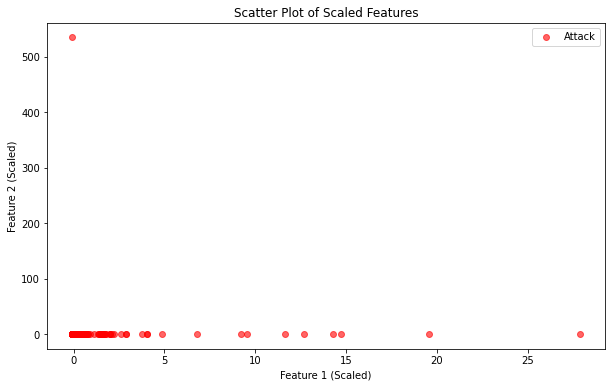

In [18]:
import matplotlib.pyplot as plt

# 选择第一个和第二个特征作为 x 和 y 轴
x_axis = X_scaled[:, 6]  # 第一个特征
y_axis = X_scaled[:, 2]  # 第二个特征

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(x_axis[y_train == 1], y_axis[y_train == 1], color='red', label='Attack', alpha=0.6)
plt.scatter(x_axis[y_train == 0], y_axis[y_train == 0], color='blue', label='Normal', alpha=0.6)

# 添加图例和标签
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.title('Scatter Plot of Scaled Features')
plt.legend()
plt.show()


In [4]:
best_model = joblib.load('Models/random_forest_model.pkl')
best_model.fit(X_scaled, y_train)

test_set_scaled = scaler.transform(imputer.transform(test_set[features]))
y_pred = best_model.predict(test_set_scaled)

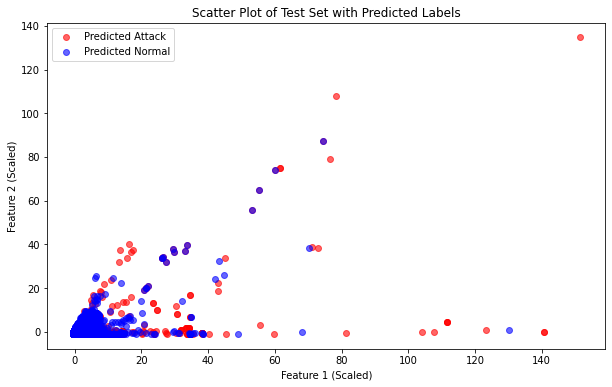

In [12]:
# 绘制test_set_scaled的散点图
plt.figure(figsize=(10, 6))

# 选择第一个和第二个特征作为 x 和 y 轴
x_axis_test = test_set_scaled[:, 4]  # 第一个特征
y_axis_test = test_set_scaled[:, 5]  # 第二个特征

# 绘制散点图，根据预测标签y_pred的值设置颜色
plt.scatter(x_axis_test[y_pred == 1], y_axis_test[y_pred == 1], color='red', label='Predicted Attack', alpha=0.6)
plt.scatter(x_axis_test[y_pred == 0], y_axis_test[y_pred == 0], color='blue', label='Predicted Normal', alpha=0.6)

# 添加图例和标签
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.title('Scatter Plot of Test Set with Predicted Labels')
plt.legend()
plt.show()
